In [1]:
# ------------------------------------------------------------------------------
# 1. SETUP & IMPORTS
# ------------------------------------------------------------------------------
import os
import time
from collections import OrderedDict
import io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Import the native file uploader for Google Colab
from google.colab import files
from IPython.display import display, clear_output

print("✅ Libraries loaded and ready.")

✅ Libraries loaded and ready.


In [2]:
# ------------------------------------------------------------------------------
# 2. CONFIGURATION
# ------------------------------------------------------------------------------
# --- Folder where the enhanced images will be saved ---
OUTPUT_DIR = '/content/enhanced_outputs/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Model & Device Configuration ---
DOWNSCALE_FACTOR = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# ------------------------------------------------------------------------------
# 3. MODEL ARCHITECTURE DEFINITION (UPDATED FOR RRDBNet)
# ------------------------------------------------------------------------------
# This architecture must be EXACTLY the same as the one used for the final training.
class ResidualDenseBlock(nn.Module):
    def __init__(self, nf=32, gc=16):
        super(ResidualDenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1); self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1); self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1); self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1); self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    def forward(self, x):
        x1 = self.lrelu(self.conv1(x)); x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1))); x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1))); x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1))); x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x

class RRDB(nn.Module):
    def __init__(self, nf, gc=16):
        super(RRDB, self).__init__(); self.RDB1 = ResidualDenseBlock(nf, gc); self.RDB2 = ResidualDenseBlock(nf, gc); self.RDB3 = ResidualDenseBlock(nf, gc)
    def forward(self, x):
        out = self.RDB1(x); out = self.RDB2(out); out = self.RDB3(out)
        return out * 0.2 + x

class RRDBNet_v9(nn.Module):
    def __init__(self, in_nc=3, out_nc=3, nf=32, nb=4, gc=16, upscale=4):
        super(RRDBNet_v9, self).__init__()
        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1)
        self.body = nn.Sequential(*[RRDB(nf, gc=gc) for _ in range(nb)])
        self.conv_body = nn.Conv2d(nf, nf, 3, 1, 1)
        self.upsampler = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(nf, nf, 3, 1, 1), nn.LeakyReLU(0.2, inplace=True), nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(nf, nf, 3, 1, 1), nn.LeakyReLU(0.2, inplace=True))
        self.conv_hr = nn.Conv2d(nf, nf, 3, 1, 1)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.conv_body(self.body(fea))
        fea = fea + trunk
        fea = self.upsampler(fea)
        fea = self.lrelu(self.conv_hr(fea))
        out = self.conv_last(fea)
        return torch.sigmoid(out)

In [4]:
# ------------------------------------------------------------------------------
# 4. HELPER FUNCTION FOR INFERENCE (FINAL HYBRID VERSION)
# ------------------------------------------------------------------------------
def enhance_image(input_pil_image, model, device):
    """
    Hybrid function that intelligently handles both high-res "demo" images
    and low-res "enhancement" images.
    """
    to_tensor = transforms.ToTensor()
    to_pil = transforms.ToPILImage()
    original_w, original_h = input_pil_image.size

    # --- This threshold determines which logic to use ---
    # If the image is large, we assume it's a high-res demo image.
    HIGH_RES_THRESHOLD = 500 # Pixels (can be adjusted)

    start_time = time.time()

    if original_w > HIGH_RES_THRESHOLD or original_h > HIGH_RES_THRESHOLD:
        # --- LOGIC 1: DEMO MODE (For High-Res Inputs like your validation images) ---
        print("-> Detected High-Res Image: Using Demo Mode (4x Upscaling).")
        # This is your original, successful logic for high-res images.
        student_input_size = (original_w // 4, original_h // 4)
        student_input_pil = input_pil_image.resize(student_input_size, Image.BICUBIC)
        student_input_tensor = to_tensor(student_input_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            output_tensor = model(student_input_tensor) # Output will be original size

        final_output_pil = to_pil(output_tensor.squeeze(0).cpu())

    else:
        # --- LOGIC 2: ENHANCEMENT MODE (For Low-Res Inputs like internet images) ---
        print("-> Detected Low-Res Image: Using Enhancement Mode (Smart Padding).")
        # This is the smart padding logic to prevent distortion on small images.
        target_aspect_ratio = 16.0 / 9.0

        if original_w / original_h > target_aspect_ratio:
            new_h = int(original_w / target_aspect_ratio)
            new_w = original_w
        else:
            new_w = int(original_h * target_aspect_ratio)
            new_h = original_h

        padded_image = Image.new("RGB", (new_w, new_h), (0, 0, 0))
        padded_image.paste(input_pil_image, ((new_w - original_w) // 2, (new_h - original_h) // 2))

        # Resize the padded image to the model's optimal input size
        student_input_pil = padded_image.resize((480, 270), Image.BICUBIC)
        student_input_tensor = to_tensor(student_input_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            output_tensor = model(student_input_tensor) # Output will be 1920x1080

        output_pil_padded = to_pil(output_tensor.squeeze(0).cpu())

        # Crop out the padding to get the final result
        crop_w = int(original_w * (output_pil_padded.width / new_w))
        crop_h = int(original_h * (output_pil_padded.height / new_h))
        crop_x = (output_pil_padded.width - crop_w) // 2
        crop_y = (output_pil_padded.height - crop_h) // 2

        final_output_pil = output_pil_padded.crop((crop_x, crop_y, crop_x + crop_w, crop_y + crop_h))

    processing_time = time.time() - start_time
    return final_output_pil, processing_time

Processing 'testface3 (1).jpg'...
-> Detected Low-Res Image: Using Enhancement Mode (Smart Padding).


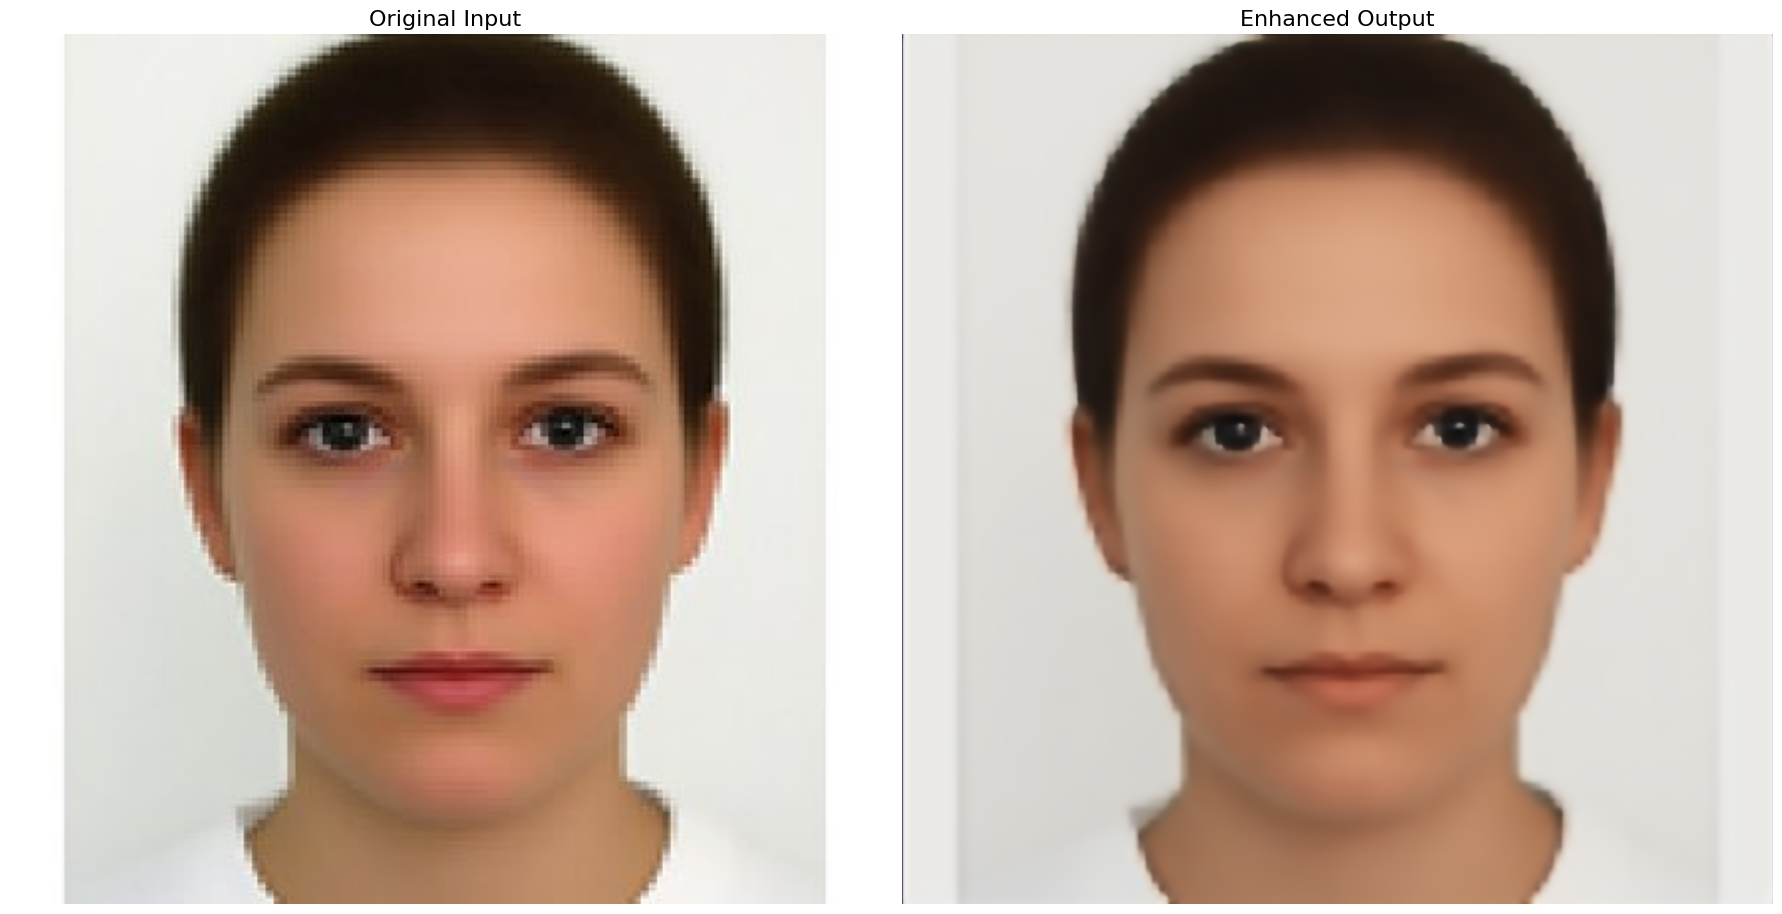


Processed in 10.6811 seconds (0.09 FPS).
✅ Saved enhanced image to: /content/enhanced_outputs/enhanced_testface3 (1).jpg


In [ ]:
# ------------------------------------------------------------------------------
# 5. MAIN EXECUTION BLOCK
# ------------------------------------------------------------------------------
def main():
    # --- STEP 1: UPLOAD AND LOAD THE MODEL ---
    print("--- Step 1: Model Upload ---")
    print("Please upload your trained RRDBNet model (.pth) file.")
    uploaded_model = files.upload()

    if not uploaded_model:
        print("❌ Model upload cancelled. Please run the cell again."); return

    model_filename = list(uploaded_model.keys())[0]
    model_weights_path = f"/content/{model_filename}"
    with open(model_weights_path, "wb") as f:
        f.write(uploaded_model[model_filename])

    print(f"\nLoading model from '{model_filename}'...")
    # UPDATED: Instantiate the correct RRDBNet_v9 model
    model = RRDBNet_v9(nf=32, nb=4, gc=16, upscale=DOWNSCALE_FACTOR).to(DEVICE)
    try:
        state_dict = torch.load(model_weights_path, map_location=DEVICE)
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] if k.startswith('module.') else k
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
        model.eval()
        print(f"✅ Model loaded successfully onto {DEVICE}.")
    except Exception as e:
        print(f"❌ FATAL ERROR loading model: {e}"); return

    # --- STEP 2: UPLOAD AND PROCESS THE IMAGE ---
    print("\n--- Step 2: Image Upload ---")
    print("Please upload the image you want to enhance.")
    uploaded_image = files.upload()

    if not uploaded_image:
        print("❌ Image upload cancelled. Please run the cell again."); return

    image_filename = list(uploaded_image.keys())[0]
    clear_output(wait=True)
    print(f"Processing '{image_filename}'...")

    try:
        input_pil = Image.open(io.BytesIO(uploaded_image[image_filename])).convert("RGB")
        enhanced_pil, proc_time = enhance_image(input_pil, model, DEVICE)

        fig, ax = plt.subplots(1, 2, figsize=(18, 9))
        ax[0].imshow(input_pil); ax[0].set_title('Original Input', fontsize=16); ax[0].axis('off')
        ax[1].imshow(enhanced_pil); ax[1].set_title('Enhanced Output', fontsize=16); ax[1].axis('off')
        plt.tight_layout(); plt.show()

        print(f"\nProcessed in {proc_time:.4f} seconds ({1/proc_time:.2f} FPS).")
        save_path = os.path.join(OUTPUT_DIR, f"enhanced_{image_filename}")
        enhanced_pil.save(save_path)
        print(f"✅ Saved enhanced image to: {save_path}")
    except Exception as e:
        print(f"❌ An error occurred during processing: {e}")

# --- Run the main function ---
if __name__ == "__main__":
    main()

Processing 'tf2.png'...
-> Detected High-Res Image: Using Demo Mode (4x Upscaling).


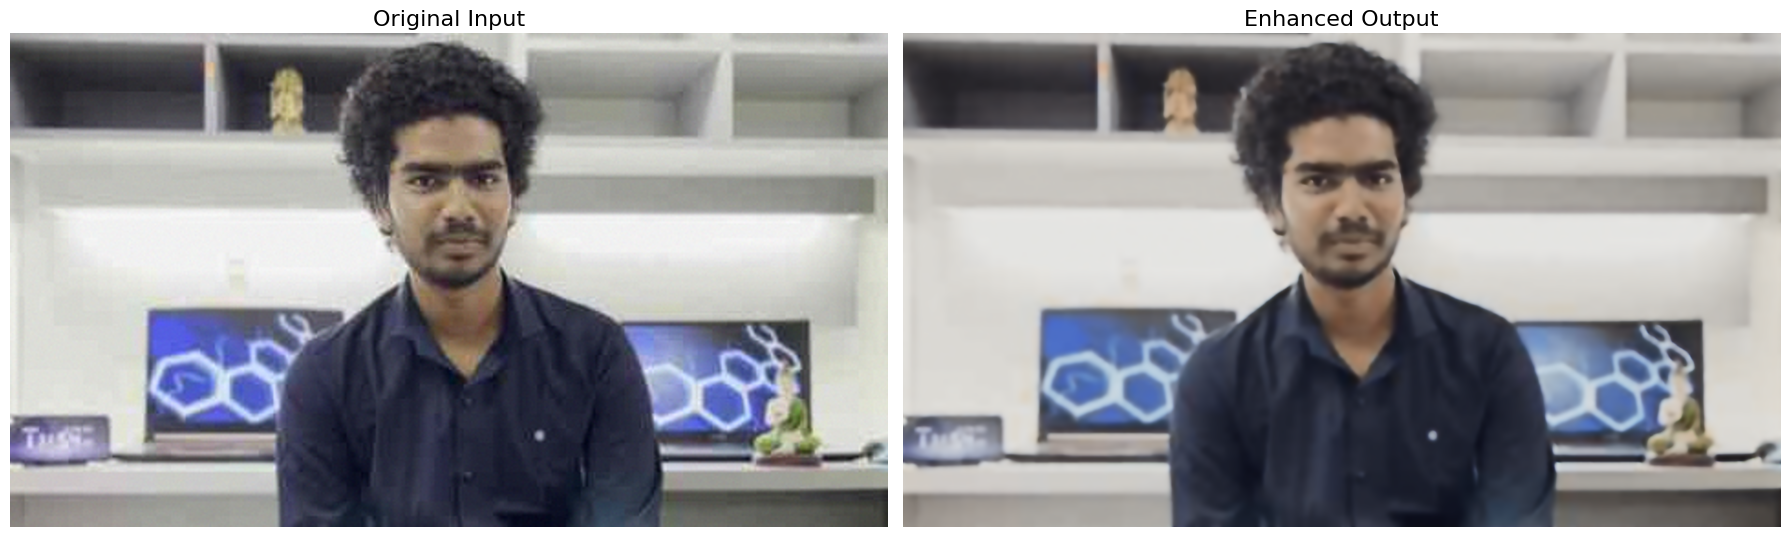


Processed in 12.9160 seconds (0.08 FPS).
✅ Saved enhanced image to: /content/enhanced_outputs/enhanced_tf2.png


In [ ]:
# ------------------------------------------------------------------------------
# 5. MAIN EXECUTION BLOCK
# ------------------------------------------------------------------------------
def main():
    # --- STEP 1: UPLOAD AND LOAD THE MODEL ---
    print("--- Step 1: Model Upload ---")
    print("Please upload your trained RRDBNet model (.pth) file.")
    uploaded_model = files.upload()

    if not uploaded_model:
        print("❌ Model upload cancelled. Please run the cell again."); return

    model_filename = list(uploaded_model.keys())[0]
    model_weights_path = f"/content/{model_filename}"
    with open(model_weights_path, "wb") as f:
        f.write(uploaded_model[model_filename])

    print(f"\nLoading model from '{model_filename}'...")
    # UPDATED: Instantiate the correct RRDBNet_v9 model
    model = RRDBNet_v9(nf=32, nb=4, gc=16, upscale=DOWNSCALE_FACTOR).to(DEVICE)
    try:
        state_dict = torch.load(model_weights_path, map_location=DEVICE)
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] if k.startswith('module.') else k
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
        model.eval()
        print(f"✅ Model loaded successfully onto {DEVICE}.")
    except Exception as e:
        print(f"❌ FATAL ERROR loading model: {e}"); return

    # --- STEP 2: UPLOAD AND PROCESS THE IMAGE ---
    print("\n--- Step 2: Image Upload ---")
    print("Please upload the image you want to enhance.")
    uploaded_image = files.upload()

    if not uploaded_image:
        print("❌ Image upload cancelled. Please run the cell again."); return

    image_filename = list(uploaded_image.keys())[0]
    clear_output(wait=True)
    print(f"Processing '{image_filename}'...")

    try:
        input_pil = Image.open(io.BytesIO(uploaded_image[image_filename])).convert("RGB")
        enhanced_pil, proc_time = enhance_image(input_pil, model, DEVICE)

        fig, ax = plt.subplots(1, 2, figsize=(18, 9))
        ax[0].imshow(input_pil); ax[0].set_title('Original Input', fontsize=16); ax[0].axis('off')
        ax[1].imshow(enhanced_pil); ax[1].set_title('Enhanced Output', fontsize=16); ax[1].axis('off')
        plt.tight_layout(); plt.show()

        print(f"\nProcessed in {proc_time:.4f} seconds ({1/proc_time:.2f} FPS).")
        save_path = os.path.join(OUTPUT_DIR, f"enhanced_{image_filename}")
        enhanced_pil.save(save_path)
        print(f"✅ Saved enhanced image to: {save_path}")
    except Exception as e:
        print(f"❌ An error occurred during processing: {e}")

# --- Run the main function ---
if __name__ == "__main__":
    main()

Processing 'tv2.png'...
-> Detected High-Res Image: Using Demo Mode (4x Upscaling).


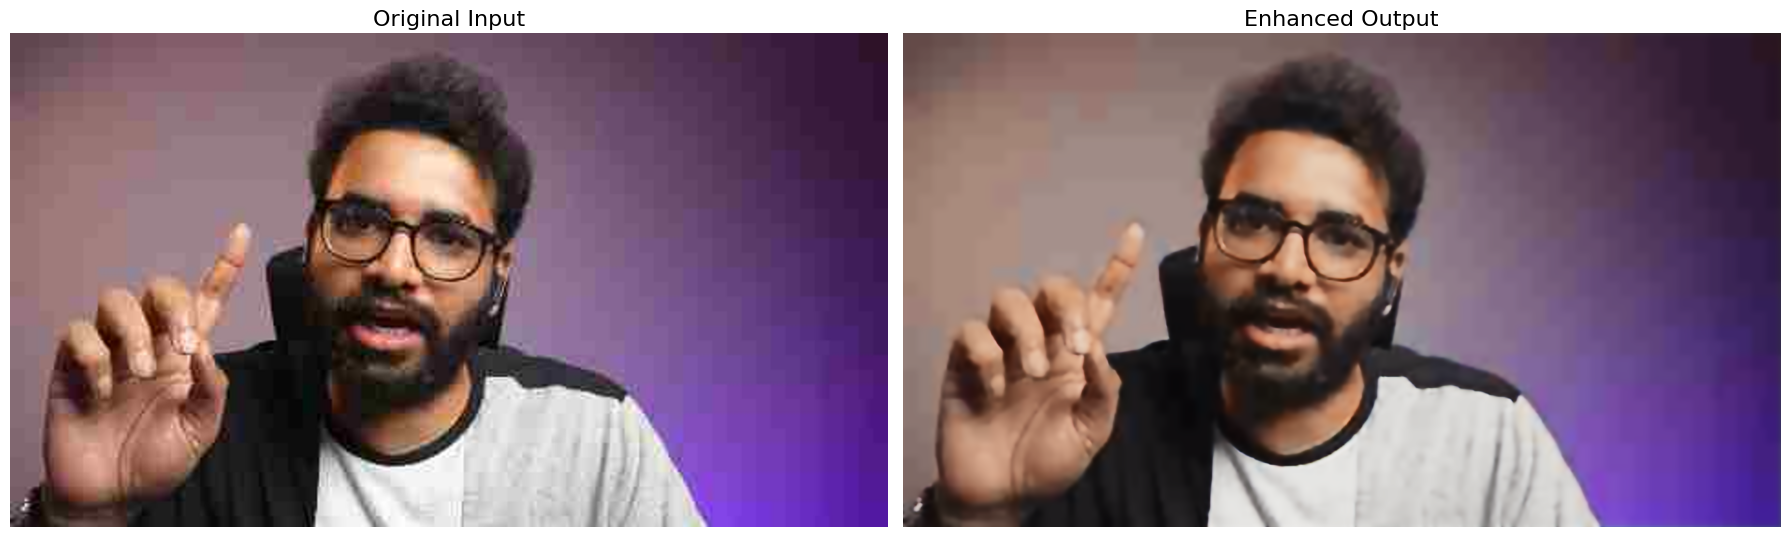


Processed in 9.5307 seconds (0.10 FPS).
✅ Saved enhanced image to: /content/enhanced_outputs/enhanced_tv2.png


In [5]:
# ------------------------------------------------------------------------------
# 5. MAIN EXECUTION BLOCK
# ------------------------------------------------------------------------------
def main():
    # --- STEP 1: UPLOAD AND LOAD THE MODEL ---
    print("--- Step 1: Model Upload ---")
    print("Please upload your trained RRDBNet model (.pth) file.")
    uploaded_model = files.upload()

    if not uploaded_model:
        print("❌ Model upload cancelled. Please run the cell again."); return

    model_filename = list(uploaded_model.keys())[0]
    model_weights_path = f"/content/{model_filename}"
    with open(model_weights_path, "wb") as f:
        f.write(uploaded_model[model_filename])

    print(f"\nLoading model from '{model_filename}'...")
    # UPDATED: Instantiate the correct RRDBNet_v9 model
    model = RRDBNet_v9(nf=32, nb=4, gc=16, upscale=DOWNSCALE_FACTOR).to(DEVICE)
    try:
        state_dict = torch.load(model_weights_path, map_location=DEVICE)
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] if k.startswith('module.') else k
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
        model.eval()
        print(f"✅ Model loaded successfully onto {DEVICE}.")
    except Exception as e:
        print(f"❌ FATAL ERROR loading model: {e}"); return

    # --- STEP 2: UPLOAD AND PROCESS THE IMAGE ---
    print("\n--- Step 2: Image Upload ---")
    print("Please upload the image you want to enhance.")
    uploaded_image = files.upload()

    if not uploaded_image:
        print("❌ Image upload cancelled. Please run the cell again."); return

    image_filename = list(uploaded_image.keys())[0]
    clear_output(wait=True)
    print(f"Processing '{image_filename}'...")

    try:
        input_pil = Image.open(io.BytesIO(uploaded_image[image_filename])).convert("RGB")
        enhanced_pil, proc_time = enhance_image(input_pil, model, DEVICE)

        fig, ax = plt.subplots(1, 2, figsize=(18, 9))
        ax[0].imshow(input_pil); ax[0].set_title('Original Input', fontsize=16); ax[0].axis('off')
        ax[1].imshow(enhanced_pil); ax[1].set_title('Enhanced Output', fontsize=16); ax[1].axis('off')
        plt.tight_layout(); plt.show()

        print(f"\nProcessed in {proc_time:.4f} seconds ({1/proc_time:.2f} FPS).")
        save_path = os.path.join(OUTPUT_DIR, f"enhanced_{image_filename}")
        enhanced_pil.save(save_path)
        print(f"✅ Saved enhanced image to: {save_path}")
    except Exception as e:
        print(f"❌ An error occurred during processing: {e}")

# --- Run the main function ---
if __name__ == "__main__":
    main()

Processing 'testface4.jpeg'...
-> Detected Low-Res Image: Using Enhancement Mode (Smart Padding).


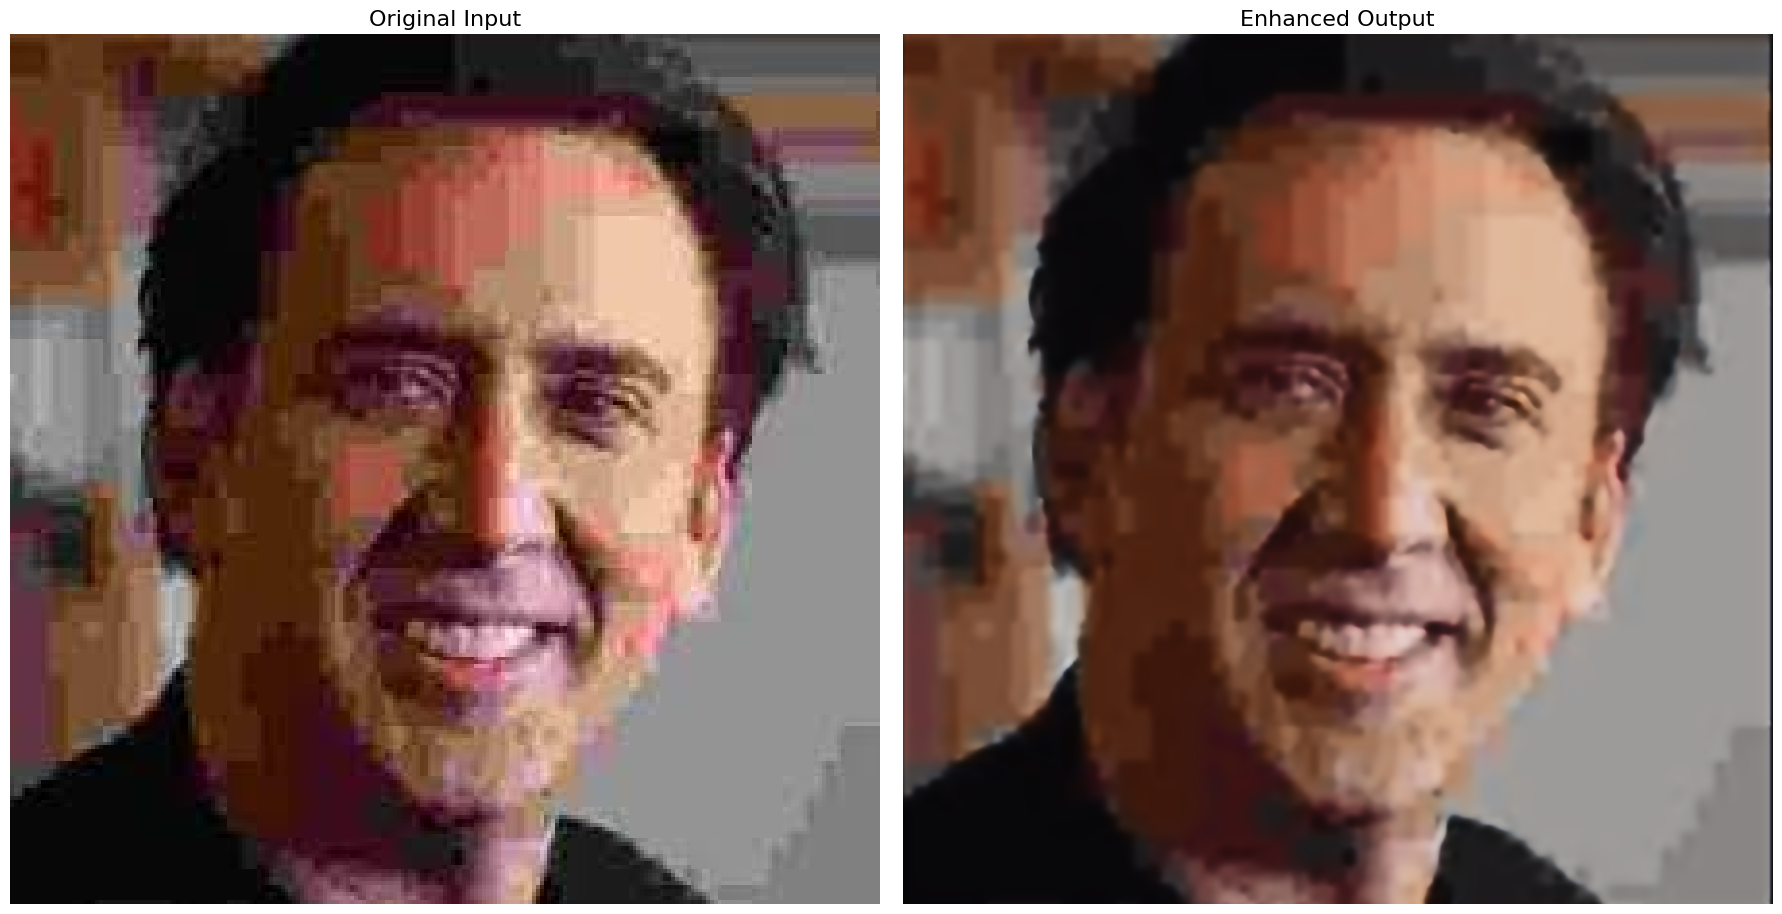


Processed in 9.5159 seconds (0.11 FPS).
✅ Saved enhanced image to: /content/enhanced_outputs/enhanced_testface4.jpeg


In [6]:
# ------------------------------------------------------------------------------
# 5. MAIN EXECUTION BLOCK
# ------------------------------------------------------------------------------
def main():
    # --- STEP 1: UPLOAD AND LOAD THE MODEL ---
    print("--- Step 1: Model Upload ---")
    print("Please upload your trained RRDBNet model (.pth) file.")
    uploaded_model = files.upload()

    if not uploaded_model:
        print("❌ Model upload cancelled. Please run the cell again."); return

    model_filename = list(uploaded_model.keys())[0]
    model_weights_path = f"/content/{model_filename}"
    with open(model_weights_path, "wb") as f:
        f.write(uploaded_model[model_filename])

    print(f"\nLoading model from '{model_filename}'...")
    # UPDATED: Instantiate the correct RRDBNet_v9 model
    model = RRDBNet_v9(nf=32, nb=4, gc=16, upscale=DOWNSCALE_FACTOR).to(DEVICE)
    try:
        state_dict = torch.load(model_weights_path, map_location=DEVICE)
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] if k.startswith('module.') else k
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
        model.eval()
        print(f"✅ Model loaded successfully onto {DEVICE}.")
    except Exception as e:
        print(f"❌ FATAL ERROR loading model: {e}"); return

    # --- STEP 2: UPLOAD AND PROCESS THE IMAGE ---
    print("\n--- Step 2: Image Upload ---")
    print("Please upload the image you want to enhance.")
    uploaded_image = files.upload()

    if not uploaded_image:
        print("❌ Image upload cancelled. Please run the cell again."); return

    image_filename = list(uploaded_image.keys())[0]
    clear_output(wait=True)
    print(f"Processing '{image_filename}'...")

    try:
        input_pil = Image.open(io.BytesIO(uploaded_image[image_filename])).convert("RGB")
        enhanced_pil, proc_time = enhance_image(input_pil, model, DEVICE)

        fig, ax = plt.subplots(1, 2, figsize=(18, 9))
        ax[0].imshow(input_pil); ax[0].set_title('Original Input', fontsize=16); ax[0].axis('off')
        ax[1].imshow(enhanced_pil); ax[1].set_title('Enhanced Output', fontsize=16); ax[1].axis('off')
        plt.tight_layout(); plt.show()

        print(f"\nProcessed in {proc_time:.4f} seconds ({1/proc_time:.2f} FPS).")
        save_path = os.path.join(OUTPUT_DIR, f"enhanced_{image_filename}")
        enhanced_pil.save(save_path)
        print(f"✅ Saved enhanced image to: {save_path}")
    except Exception as e:
        print(f"❌ An error occurred during processing: {e}")

# --- Run the main function ---
if __name__ == "__main__":
    main()

In [ ]:
# ==============================================================================
#                      GPU / HARDWARE ACCELERATOR CHECK
# ==============================================================================
# Run this cell first to verify that a GPU is active in your Colab session.

import torch

if torch.cuda.is_available():
  # Print the name of the GPU for confirmation
  print(f"✅ GPU is available! Device: {torch.cuda.get_device_name(0)}")
  print("You are all set to run the main benchmarking script with high performance.")
else:
  print("⚠️ WARNING: No GPU detected. The main script will run on CPU and will be very slow.")
  print("Go to 'Runtime' -> 'Change runtime type' and select 'GPU' as the hardware accelerator.")

✅ GPU is available! Device: Tesla T4
You are all set to run the main benchmarking script with high performance.


In [ ]:
#--- upsacling for a batch of images and calculating the metrics ---

In [ ]:
# ==============================================================================
#      INTELLIGENT BATCH BENCHMARKING SCRIPT V3 (Corrected Logic)
# ==============================================================================
# This script uses an 'LR' and 'HR' folder. For each image from the LR folder,
# it automatically detects if it should be treated as a "High-Res Blurry" or
# "Low-Res Blurry" image based on its dimensions, and applies the correct logic.
#
# - If LR image is LARGE (High-Res Blurry):
#   It is first SHRUNK, then enhanced. SSIM is calculated against HR.
#
# - If LR image is SMALL (Low-Res Blurry):
#   It is used DIRECTLY as input, then enhanced. SSIM is calculated against HR.
# ==============================================================================

# ==============================================================================
#                          1. CONFIGURATION
# ==============================================================================
# --- CHOOSE WHICH MODEL TO TEST ---
MODEL_TO_TEST = 'STUDENT'  # Options: 'STUDENT' or 'TEACHER'

# --- SET THE DIMENSION THRESHOLD ---
# Any image in the LR folder with more pixels than this will trigger the "shrink-first" logic.
DEMO_MODE_THRESHOLD_PIXELS = 500000  # (e.g., approx 800x600 pixels)

# ==============================================================================
#                          2. IMPORTS & SETUP
# ==============================================================================
import os
import io
import zipfile
import time
from glob import glob
from collections import OrderedDict
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from google.colab import files
from torchvision import transforms

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DOWNSCALE_FACTOR = 4

# ==============================================================================
#                         3. ALL MODEL DEFINITIONS
# ==============================================================================
class Teacher_UNet_Wider(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=96):
        super(Teacher_UNet_Wider,self).__init__();self.down1=nn.Sequential(nn.Conv2d(in_channels,features,3,1,1),nn.ReLU(inplace=True),nn.Conv2d(features,features,3,1,1),nn.ReLU(inplace=True));self.pool1=nn.MaxPool2d(2,2);self.bottleneck=nn.Sequential(nn.Conv2d(features,features*2,3,1,1),nn.ReLU(inplace=True),nn.Conv2d(features*2,features*2,3,1,1),nn.ReLU(inplace=True));self.up_conv1=nn.ConvTranspose2d(features*2,features,2,2);self.decoder1=nn.Sequential(nn.Conv2d(features*2,features,3,1,1),nn.ReLU(inplace=True),nn.Conv2d(features,features,3,1,1),nn.ReLU(inplace=True));self.final_conv=nn.Conv2d(features,out_channels,1,1,0)
    def forward(self,x):
        d1=self.down1(x);p1=self.pool1(d1);b=self.bottleneck(p1);u1=self.up_conv1(b);skip=torch.cat([u1,d1],dim=1);dec1=self.decoder1(skip);residual_output=torch.tanh(self.final_conv(dec1));return residual_output,{'bottleneck':b}
class ResidualDenseBlock(nn.Module):
    def __init__(self, nf=32, gc=16):
        super(ResidualDenseBlock,self).__init__();self.conv1=nn.Conv2d(nf,gc,3,1,1);self.conv2=nn.Conv2d(nf+gc,gc,3,1,1);self.conv3=nn.Conv2d(nf+2*gc,gc,3,1,1);self.conv4=nn.Conv2d(nf+3*gc,gc,3,1,1);self.conv5=nn.Conv2d(nf+4*gc,nf,3,1,1);self.lrelu=nn.LeakyReLU(negative_slope=0.2,inplace=True)
    def forward(self,x):
        x1=self.lrelu(self.conv1(x));x2=self.lrelu(self.conv2(torch.cat((x,x1),1)));x3=self.lrelu(self.conv3(torch.cat((x,x1,x2),1)));x4=self.lrelu(self.conv4(torch.cat((x,x1,x2,x3),1)));x5=self.conv5(torch.cat((x,x1,x2,x3,x4),1));return x5*0.2+x
class RRDB(nn.Module):
    def __init__(self,nf,gc=16):
        super(RRDB,self).__init__();self.RDB1=ResidualDenseBlock(nf,gc);self.RDB2=ResidualDenseBlock(nf,gc);self.RDB3=ResidualDenseBlock(nf,gc)
    def forward(self,x):
        out=self.RDB1(x);out=self.RDB2(out);out=self.RDB3(out);return out*0.2+x
class RRDBNet_v9(nn.Module):
    def __init__(self,in_nc=3,out_nc=3,nf=32,nb=4,gc=16,upscale=4):
        super(RRDBNet_v9,self).__init__();self.conv_first=nn.Conv2d(in_nc,nf,3,1,1);self.body=nn.Sequential(*[RRDB(nf,gc=gc) for _ in range(nb)]);self.conv_body=nn.Conv2d(nf,nf,3,1,1);self.upsampler=nn.Sequential(nn.Upsample(scale_factor=2,mode='nearest'),nn.Conv2d(nf,nf,3,1,1),nn.LeakyReLU(0.2,inplace=True),nn.Upsample(scale_factor=2,mode='nearest'),nn.Conv2d(nf,nf,3,1,1),nn.LeakyReLU(0.2,inplace=True));self.conv_hr=nn.Conv2d(nf,nf,3,1,1);self.conv_last=nn.Conv2d(nf,out_nc,3,1,1);self.lrelu=nn.LeakyReLU(negative_slope=0.2,inplace=True)
    def forward(self,x):
        fea=self.conv_first(x);trunk=self.conv_body(self.body(fea));fea=fea+trunk;fea=self.upsampler(fea);fea=self.lrelu(self.conv_hr(fea));out=self.conv_last(fea);return torch.sigmoid(out)

# ==============================================================================
#                          4. MAIN EXECUTION (CORRECTED & CLEANED)
# ==============================================================================

def main():
    print(f"--- INTELLIGENT BATCH PROCESSING FOR {MODEL_TO_TEST} MODEL ---")
    OUTPUT_DIR = f'/content/{MODEL_TO_TEST.lower()}_auto_results/'
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # --- Step 1: Instantiate and Load the correct model ---
    print(f"\n--- Step 1: Upload {MODEL_TO_TEST} Model ---")
    if MODEL_TO_TEST == 'STUDENT':
        model = RRDBNet_v9(nf=32, nb=4, gc=16, upscale=DOWNSCALE_FACTOR).to(DEVICE)
    else: # TEACHER
        model = Teacher_UNet_Wider(features=96).to(DEVICE)

    uploaded_model_file = files.upload()
    if not uploaded_model_file: return

    try:
        state_dict = torch.load(io.BytesIO(list(uploaded_model_file.values())[0]), map_location=DEVICE)
        new_state_dict = OrderedDict([(k[7:] if k.startswith('module.') else k, v) for k, v in state_dict.items()])
        model.load_state_dict(new_state_dict)
        model.eval()
        print(f"✅ {MODEL_TO_TEST} model loaded successfully.")
    except Exception as e: print(f"❌ FATAL ERROR loading model: {e}"); return

    # --- Step 2: Upload and Unzip Data ---
    print("\n--- Step 2: Dataset Upload ---")
    print("Please upload your .zip file containing 'student_lr' and 'hr' folders.")
    uploaded_zip = files.upload()
    if not uploaded_zip: return

    extract_path = '/content/temp_dataset'
    with zipfile.ZipFile(io.BytesIO(list(uploaded_zip.values())[0]), 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # --- THIS IS THE CORRECT, CONSOLIDATED LOGIC FOR FINDING DATA ---
    print(f"Searching for 'student_lr' and 'hr' directories inside the unzipped folder...")
    base_lr_dir = None
    base_hr_dir = None
    # Search for the folders case-insensitively, wherever they are
    for root, dirs, _ in os.walk(extract_path):
        for d in dirs:
            if d.lower() == 'student_lr':
                base_lr_dir = os.path.join(root, d)
            if d.lower() == 'hr':
                base_hr_dir = os.path.join(root, d)
        if base_lr_dir and base_hr_dir:
            break

    if not base_lr_dir or not base_hr_dir:
        print("❌ Search failed. Could not find 'student_lr' and/or 'hr' directories anywhere inside the zip file.")
        return
    else:
        print(f"✅ Found LR directory at: {base_lr_dir}")
        print(f"✅ Found HR directory at: {base_hr_dir}")

    # Use the single, powerful glob command to find all images recursively
    print("Searching for all images within the LR directory structure...")
    lr_image_paths = sorted(glob(os.path.join(base_lr_dir, '**', '*.*'), recursive=True))
    lr_image_paths = [f for f in lr_image_paths if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

    if not lr_image_paths:
        print(f"❌ No images found in the '{os.path.basename(base_lr_dir)}' directory or its subfolders.")
        return
    print(f"✅ Found {len(lr_image_paths)} images to process.")


    # --- Step 3: Process all images ---
    all_ssim_scores, all_inference_times = [], []
    demo_mode_count, enhance_mode_count = 0, 0
    ssim_metric = SSIM(data_range=1.0).to(DEVICE)
    to_tensor = transforms.ToTensor()
    to_pil = transforms.ToPILImage()

    print(f"\n--- Step 3: Processing images with Auto-Detection Logic ---")
    for lr_path in tqdm(lr_image_paths):
        try:
            # Construct the corresponding hr_path by replacing the base directory paths
            hr_path = lr_path.replace(base_lr_dir, base_hr_dir)

            if not os.path.exists(hr_path):
                print(f"Warning: No matching HR image found for {os.path.basename(lr_path)}. Skipping.")
                continue

            base_filename = os.path.basename(lr_path)
            lr_pil = Image.open(lr_path).convert("RGB")
            hr_pil = Image.open(hr_path).convert("RGB")
            w, h = lr_pil.size
            is_large_blurry_image = (w * h) > DEMO_MODE_THRESHOLD_PIXELS

            # --- Prepare the actual input for the model based on the logic ---
            if is_large_blurry_image:
                demo_mode_count += 1
                input_for_model_pil = lr_pil.resize((w // DOWNSCALE_FACTOR, h // DOWNSCALE_FACTOR), Image.BICUBIC)
            else:
                enhance_mode_count += 1
                input_for_model_pil = lr_pil

            # --- Handle model-specific input requirements ---
            if MODEL_TO_TEST == 'TEACHER':
                input_tensor_for_model = to_tensor(input_for_model_pil.resize(hr_pil.size, Image.BICUBIC)).unsqueeze(0).to(DEVICE)
            else: # STUDENT
                input_tensor_for_model = to_tensor(input_for_model_pil).unsqueeze(0).to(DEVICE)

            # --- Run Inference ---
            start_time = time.time()
            with torch.no_grad():
                if MODEL_TO_TEST == 'STUDENT':
                    output_tensor = model(input_tensor_for_model)
                else: # TEACHER
                    teacher_residual, _ = model(input_tensor_for_model)
                    output_tensor = (input_tensor_for_model + teacher_residual)
            proc_time = time.time() - start_time
            all_inference_times.append(proc_time)

            # --- Post-process, save, and calculate metrics ---
            enhanced_pil = to_pil(output_tensor.clamp(0, 1).squeeze(0).cpu())
            enhanced_pil.save(os.path.join(OUTPUT_DIR, f"enhanced_{base_filename}"))

            hr_pil_resized = hr_pil.resize(enhanced_pil.size, Image.BICUBIC)
            hr_tensor = to_tensor(hr_pil_resized).unsqueeze(0).to(DEVICE)
            ssim_score = ssim_metric(output_tensor.clamp(0, 1), hr_tensor)
            all_ssim_scores.append(ssim_score.item())

        except Exception as e:
            print(f"Skipping {base_filename} due to an error: {e}")

    # --- Step 4: Final Report ---
    if all_inference_times:
        avg_time = np.mean(all_inference_times)
        avg_fps = 1.0 / avg_time
        avg_ssim = np.mean(all_ssim_scores)

        print("\n" + "="*60)
        print(f"        {MODEL_TO_TEST} MODEL - AUTO-DETECT BENCHMARK REPORT")
        print("="*60)
        print(f"Total Images Processed:        {len(all_inference_times)}")
        print(f" - 'Demo' Mode (Shrink First): {demo_mode_count} images")
        print(f" - 'Enhance' Mode (Direct):    {enhance_mode_count} images")
        print("-" * 60)
        print(f"Average Inference Time:        {avg_time:.4f} seconds/image")
        print(f"Average FPS:                   {avg_fps:.2f}")
        print(f"Average SSIM Score (All):      {avg_ssim:.4f}")
        print(f"\n✅ All enhanced images saved to: {OUTPUT_DIR}")
        print("="*60)

# --- Run the main function ---
if __name__ == "__main__":
    main()

In [ ]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
# ==============================================================================
#      INTELLIGENT BATCH BENCHMARKING SCRIPT V4 (Corrected & Cleaned)
# ==============================================================================
# This script uses an 'LR' and 'HR' folder. For each image from the LR folder,
# it automatically detects if it should be treated as a "High-Res Blurry" or
# "Low-Res Blurry" image based on its dimensions, and applies the correct logic.
#
# - If LR image is LARGE (High-Res Blurry):
#   It is first SHRUNK, then enhanced. SSIM is calculated against HR.
#
# - If LR image is SMALL (Low-Res Blurry):
#   It is used DIRECTLY as input, then enhanced. SSIM is calculated against HR.
# ==============================================================================

# ==============================================================================
#                          1. CONFIGURATION
# ==============================================================================
# --- CHOOSE WHICH MODEL TO TEST ---
MODEL_TO_TEST = 'STUDENT'  # Options: 'STUDENT' or 'TEACHER'

# --- SET THE DIMENSION THRESHOLD ---
# Any image in the LR folder with more pixels than this will trigger the "shrink-first" logic.
DEMO_MODE_THRESHOLD_PIXELS = 500000  # (e.g., approx 800x600 pixels)

# ==============================================================================
#                          2. IMPORTS & SETUP
# ==============================================================================
import os
import io
import zipfile
import time
from glob import glob
from collections import OrderedDict
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from google.colab import files
from torchvision import transforms

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DOWNSCALE_FACTOR = 4

# ==============================================================================
#                         3. ALL MODEL DEFINITIONS
# ==============================================================================
class Teacher_UNet_Wider(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=96):
        super(Teacher_UNet_Wider,self).__init__();self.down1=nn.Sequential(nn.Conv2d(in_channels,features,3,1,1),nn.ReLU(inplace=True),nn.Conv2d(features,features,3,1,1),nn.ReLU(inplace=True));self.pool1=nn.MaxPool2d(2,2);self.bottleneck=nn.Sequential(nn.Conv2d(features,features*2,3,1,1),nn.ReLU(inplace=True),nn.Conv2d(features*2,features*2,3,1,1),nn.ReLU(inplace=True));self.up_conv1=nn.ConvTranspose2d(features*2,features,2,2);self.decoder1=nn.Sequential(nn.Conv2d(features*2,features,3,1,1),nn.ReLU(inplace=True),nn.Conv2d(features,features,3,1,1),nn.ReLU(inplace=True));self.final_conv=nn.Conv2d(features,out_channels,1,1,0)
    def forward(self,x):
        d1=self.down1(x);p1=self.pool1(d1);b=self.bottleneck(p1);u1=self.up_conv1(b);skip=torch.cat([u1,d1],dim=1);dec1=self.decoder1(skip);residual_output=torch.tanh(self.final_conv(dec1));return residual_output,{'bottleneck':b}
class ResidualDenseBlock(nn.Module):
    def __init__(self, nf=32, gc=16):
        super(ResidualDenseBlock,self).__init__();self.conv1=nn.Conv2d(nf,gc,3,1,1);self.conv2=nn.Conv2d(nf+gc,gc,3,1,1);self.conv3=nn.Conv2d(nf+2*gc,gc,3,1,1);self.conv4=nn.Conv2d(nf+3*gc,gc,3,1,1);self.conv5=nn.Conv2d(nf+4*gc,nf,3,1,1);self.lrelu=nn.LeakyReLU(negative_slope=0.2,inplace=True)
    def forward(self,x):
        x1=self.lrelu(self.conv1(x));x2=self.lrelu(self.conv2(torch.cat((x,x1),1)));x3=self.lrelu(self.conv3(torch.cat((x,x1,x2),1)));x4=self.lrelu(self.conv4(torch.cat((x,x1,x2,x3),1)));x5=self.conv5(torch.cat((x,x1,x2,x3,x4),1));return x5*0.2+x
class RRDB(nn.Module):
    def __init__(self,nf,gc=16):
        super(RRDB,self).__init__();self.RDB1=ResidualDenseBlock(nf,gc);self.RDB2=ResidualDenseBlock(nf,gc);self.RDB3=ResidualDenseBlock(nf,gc)
    def forward(self,x):
        out=self.RDB1(x);out=self.RDB2(out);out=self.RDB3(out);return out*0.2+x
class RRDBNet_v9(nn.Module):
    def __init__(self,in_nc=3,out_nc=3,nf=32,nb=4,gc=16,upscale=4):
        super(RRDBNet_v9,self).__init__();self.conv_first=nn.Conv2d(in_nc,nf,3,1,1);self.body=nn.Sequential(*[RRDB(nf,gc=gc) for _ in range(nb)]);self.conv_body=nn.Conv2d(nf,nf,3,1,1);self.upsampler=nn.Sequential(nn.Upsample(scale_factor=2,mode='nearest'),nn.Conv2d(nf,nf,3,1,1),nn.LeakyReLU(0.2,inplace=True),nn.Upsample(scale_factor=2,mode='nearest'),nn.Conv2d(nf,nf,3,1,1),nn.LeakyReLU(0.2,inplace=True));self.conv_hr=nn.Conv2d(nf,nf,3,1,1);self.conv_last=nn.Conv2d(nf,out_nc,3,1,1);self.lrelu=nn.LeakyReLU(negative_slope=0.2,inplace=True)
    def forward(self,x):
        fea=self.conv_first(x);trunk=self.conv_body(self.body(fea));fea=fea+trunk;fea=self.upsampler(fea);fea=self.lrelu(self.conv_hr(fea));out=self.conv_last(fea);return torch.sigmoid(out)

# ==============================================================================
#                          4. MAIN EXECUTION
# ==============================================================================

# THE FIX: Add the "def main():" line back in
def main():
    # All the code below this line is now correctly indented inside the function
    print(f"--- INTELLIGENT BATCH PROCESSING FOR {MODEL_TO_TEST} MODEL ---")
    OUTPUT_DIR = f'/content/{MODEL_TO_TEST.lower()}_auto_results/'
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # --- Step 1: Instantiate and Load the correct model ---
    print(f"\n--- Step 1: Upload {MODEL_TO_TEST} Model ---")
    if MODEL_TO_TEST == 'STUDENT':
        model = RRDBNet_v9(nf=32, nb=4, gc=16, upscale=DOWNSCALE_FACTOR).to(DEVICE)
    else: # TEACHER
        model = Teacher_UNet_Wider(features=96).to(DEVICE)

    uploaded_model_file = files.upload()
    if not uploaded_model_file: return

    try:
        state_dict = torch.load(io.BytesIO(list(uploaded_model_file.values())[0]), map_location=DEVICE)
        new_state_dict = OrderedDict([(k[7:] if k.startswith('module.') else k, v) for k, v in state_dict.items()])
        model.load_state_dict(new_state_dict)
        model.eval()
        print(f"✅ {MODEL_TO_TEST} model loaded successfully.")
    except Exception as e: print(f"❌ FATAL ERROR loading model: {e}"); return

    # --- Step 2: Upload and Unzip Data ---
    print("\n--- Step 2: Dataset Upload ---")
    print("Please upload your .zip file containing 'student_lr' and 'hr' folders.")
    uploaded_zip = files.upload()
    if not uploaded_zip: return

    extract_path = '/content/temp_dataset'
    with zipfile.ZipFile(io.BytesIO(list(uploaded_zip.values())[0]), 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print(f"Searching for 'student_lr' and 'hr' directories inside the unzipped folder...")
    base_lr_dir = None
    base_hr_dir = None
    for root, dirs, _ in os.walk(extract_path):
        for d in dirs:
            if d.lower() == 'student_lr':
                base_lr_dir = os.path.join(root, d)
            if d.lower() == 'hr':
                base_hr_dir = os.path.join(root, d)
        if base_lr_dir and base_hr_dir:
            break

    if not base_lr_dir or not base_hr_dir:
        print("❌ Search failed. Could not find 'student_lr' and/or 'hr' directories anywhere inside the zip file.")
        return
    else:
        print(f"✅ Found LR directory at: {base_lr_dir}")
        print(f"✅ Found HR directory at: {base_hr_dir}")

    print("Searching for all images within the LR directory structure...")
    lr_image_paths = sorted(glob(os.path.join(base_lr_dir, '**', '*.*'), recursive=True))
    lr_image_paths = [f for f in lr_image_paths if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

    if not lr_image_paths:
        print(f"❌ No images found in the '{os.path.basename(base_lr_dir)}' directory or its subfolders.")
        return
    print(f"✅ Found {len(lr_image_paths)} images to process.")


    # --- Step 3: Process all images ---
    all_ssim_scores, all_inference_times = [], []
    demo_mode_count, enhance_mode_count = 0, 0
    ssim_metric = SSIM(data_range=1.0).to(DEVICE)
    to_tensor = transforms.ToTensor()
    to_pil = transforms.ToPILImage()

    print(f"\n--- Step 3: Processing images with Auto-Detection Logic ---")
    for lr_path in tqdm(lr_image_paths):
        try:
            hr_path = lr_path.replace(base_lr_dir, base_hr_dir)
            if not os.path.exists(hr_path):
                print(f"Warning: No matching HR image found for {os.path.basename(lr_path)}. Skipping.")
                continue

            base_filename = os.path.basename(lr_path)
            lr_pil = Image.open(lr_path).convert("RGB")
            hr_pil = Image.open(hr_path).convert("RGB")
            w, h = lr_pil.size
            is_large_blurry_image = (w * h) > DEMO_MODE_THRESHOLD_PIXELS

            if is_large_blurry_image:
                demo_mode_count += 1
                input_for_model_pil = lr_pil.resize((w // DOWNSCALE_FACTOR, h // DOWNSCALE_FACTOR), Image.BICUBIC)
            else:
                enhance_mode_count += 1
                input_for_model_pil = lr_pil

            if MODEL_TO_TEST == 'TEACHER':
                input_tensor_for_model = to_tensor(input_for_model_pil.resize(hr_pil.size, Image.BICUBIC)).unsqueeze(0).to(DEVICE)
            else: # STUDENT
                input_tensor_for_model = to_tensor(input_for_model_pil).unsqueeze(0).to(DEVICE)

            start_time = time.time()
            with torch.no_grad():
                if MODEL_TO_TEST == 'STUDENT':
                    output_tensor = model(input_tensor_for_model)
                else: # TEACHER
                    teacher_residual, _ = model(input_tensor_for_model)
                    output_tensor = (input_tensor_for_model + teacher_residual)
            proc_time = time.time() - start_time
            all_inference_times.append(proc_time)

            enhanced_pil = to_pil(output_tensor.clamp(0, 1).squeeze(0).cpu())

            input_for_model_pil.save(os.path.join(OUTPUT_DIR, f"lr_input_{base_filename}"))
            enhanced_pil.save(os.path.join(OUTPUT_DIR, f"enhanced_{base_filename}"))

            hr_pil_resized = hr_pil.resize(enhanced_pil.size, Image.BICUBIC)
            hr_tensor = to_tensor(hr_pil_resized).unsqueeze(0).to(DEVICE)
            ssim_score = ssim_metric(output_tensor.clamp(0, 1), hr_tensor)
            all_ssim_scores.append(ssim_score.item())

        except Exception as e:
            print(f"Skipping {base_filename} due to an error: {e}")

    # --- Step 4: Final Report ---
    if all_inference_times:
        avg_time = np.mean(all_inference_times)
        avg_fps = 1.0 / avg_time
        avg_ssim = np.mean(all_ssim_scores)

        print("\n" + "="*60)
        print(f"        {MODEL_TO_TEST} MODEL - AUTO-DETECT BENCHMARK REPORT")
        print("="*60)
        print(f"Total Images Processed:        {len(all_inference_times)}")
        print(f" - 'Demo' Mode (Shrink First): {demo_mode_count} images")
        print(f" - 'Enhance' Mode (Direct):    {enhance_mode_count} images")
        print("-" * 60)
        print(f"Average Inference Time:        {avg_time:.4f} seconds/image")
        print(f"Average FPS:                   {avg_fps:.2f}")
        print(f"Average SSIM Score (All):      {avg_ssim:.4f}")
        print(f"\n✅ All enhanced outputs and their corresponding inputs saved to: {OUTPUT_DIR}")
        print("="*60)

# --- Run the main function ---
if __name__ == "__main__":
    main()

--- INTELLIGENT BATCH PROCESSING FOR STUDENT MODEL ---

--- Step 1: Upload STUDENT Model ---


Saving best_v9_RRDB_model.pth to best_v9_RRDB_model (1).pth
✅ STUDENT model loaded successfully.

--- Step 2: Dataset Upload ---
Please upload your .zip file containing 'student_lr' and 'hr' folders.


Saving finaltest_KD.zip to finaltest_KD (1).zip
Searching for 'student_lr' and 'hr' directories inside the unzipped folder...
✅ Found LR directory at: /content/temp_dataset/finaltest_KD/student_lr
✅ Found HR directory at: /content/temp_dataset/finaltest_KD/hr
Searching for all images within the LR directory structure...
✅ Found 86 images to process.

--- Step 3: Processing images with Auto-Detection Logic ---


  0%|          | 0/86 [00:00<?, ?it/s]


        STUDENT MODEL - AUTO-DETECT BENCHMARK REPORT
Total Images Processed:        86
 - 'Demo' Mode (Shrink First): 21 images
 - 'Enhance' Mode (Direct):    65 images
------------------------------------------------------------
Average Inference Time:        0.0139 seconds/image
Average FPS:                   72.06
Average SSIM Score (All):      0.8782

✅ All enhanced outputs and their corresponding inputs saved to: /content/student_auto_results/


In [ ]:
#--_ testing student on both Fps ---

In [ ]:
!pip install torchmetrics

In [ ]:
# ==============================================================================
#      INTELLIGENT BATCH BENCHMARKING SCRIPT V5 (Dual FPS Measurement)
# ==============================================================================
# This version now calculates both the pure Model FPS and the overall System FPS
# to show the impact of file I/O (loading/saving).
# ==============================================================================

# ==============================================================================
#                          1. CONFIGURATION
# ==============================================================================
MODEL_TO_TEST = 'STUDENT'
DEMO_MODE_THRESHOLD_PIXELS = 500000

# ==============================================================================
#                          2. IMPORTS & SETUP
# ==============================================================================
import os
import io
import zipfile
import time
from glob import glob
from collections import OrderedDict
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from google.colab import files
from torchvision import transforms

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DOWNSCALE_FACTOR = 4

# ==============================================================================
#                         3. ALL MODEL DEFINITIONS
# ==============================================================================
# (Model definitions are the same, so they are collapsed for brevity)
class Teacher_UNet_Wider(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=96):
        super(Teacher_UNet_Wider,self).__init__();self.down1=nn.Sequential(nn.Conv2d(in_channels,features,3,1,1),nn.ReLU(inplace=True),nn.Conv2d(features,features,3,1,1),nn.ReLU(inplace=True));self.pool1=nn.MaxPool2d(2,2);self.bottleneck=nn.Sequential(nn.Conv2d(features,features*2,3,1,1),nn.ReLU(inplace=True),nn.Conv2d(features*2,features*2,3,1,1),nn.ReLU(inplace=True));self.up_conv1=nn.ConvTranspose2d(features*2,features,2,2);self.decoder1=nn.Sequential(nn.Conv2d(features*2,features,3,1,1),nn.ReLU(inplace=True),nn.Conv2d(features,features,3,1,1),nn.ReLU(inplace=True));self.final_conv=nn.Conv2d(features,out_channels,1,1,0)
    def forward(self,x):
        d1=self.down1(x);p1=self.pool1(d1);b=self.bottleneck(p1);u1=self.up_conv1(b);skip=torch.cat([u1,d1],dim=1);dec1=self.decoder1(skip);residual_output=torch.tanh(self.final_conv(dec1));return residual_output,{'bottleneck':b}
class ResidualDenseBlock(nn.Module):
    def __init__(self, nf=32, gc=16):
        super(ResidualDenseBlock,self).__init__();self.conv1=nn.Conv2d(nf,gc,3,1,1);self.conv2=nn.Conv2d(nf+gc,gc,3,1,1);self.conv3=nn.Conv2d(nf+2*gc,gc,3,1,1);self.conv4=nn.Conv2d(nf+3*gc,gc,3,1,1);self.conv5=nn.Conv2d(nf+4*gc,nf,3,1,1);self.lrelu=nn.LeakyReLU(negative_slope=0.2,inplace=True)
    def forward(self,x):
        x1=self.lrelu(self.conv1(x));x2=self.lrelu(self.conv2(torch.cat((x,x1),1)));x3=self.lrelu(self.conv3(torch.cat((x,x1,x2),1)));x4=self.lrelu(self.conv4(torch.cat((x,x1,x2,x3),1)));x5=self.conv5(torch.cat((x,x1,x2,x3,x4),1));return x5*0.2+x
class RRDB(nn.Module):
    def __init__(self,nf,gc=16):
        super(RRDB,self).__init__();self.RDB1=ResidualDenseBlock(nf,gc);self.RDB2=ResidualDenseBlock(nf,gc);self.RDB3=ResidualDenseBlock(nf,gc)
    def forward(self,x):
        out=self.RDB1(x);out=self.RDB2(out);out=self.RDB3(out);return out*0.2+x
class RRDBNet_v9(nn.Module):
    def __init__(self,in_nc=3,out_nc=3,nf=32,nb=4,gc=16,upscale=4):
        super(RRDBNet_v9,self).__init__();self.conv_first=nn.Conv2d(in_nc,nf,3,1,1);self.body=nn.Sequential(*[RRDB(nf,gc=gc) for _ in range(nb)]);self.conv_body=nn.Conv2d(nf,nf,3,1,1);self.upsampler=nn.Sequential(nn.Upsample(scale_factor=2,mode='nearest'),nn.Conv2d(nf,nf,3,1,1),nn.LeakyReLU(0.2,inplace=True),nn.Upsample(scale_factor=2,mode='nearest'),nn.Conv2d(nf,nf,3,1,1),nn.LeakyReLU(0.2,inplace=True));self.conv_hr=nn.Conv2d(nf,nf,3,1,1);self.conv_last=nn.Conv2d(nf,out_nc,3,1,1);self.lrelu=nn.LeakyReLU(negative_slope=0.2,inplace=True)
    def forward(self,x):
        fea=self.conv_first(x);trunk=self.conv_body(self.body(fea));fea=fea+trunk;fea=self.upsampler(fea);fea=self.lrelu(self.conv_hr(fea));out=self.conv_last(fea);return torch.sigmoid(out)

# ==============================================================================
#                          4. MAIN EXECUTION
# ==============================================================================
def main():
    # ... (Setup code is the same) ...
    print(f"--- INTELLIGENT BATCH PROCESSING FOR {MODEL_TO_TEST} MODEL ---")
    OUTPUT_DIR = f'/content/{MODEL_TO_TEST.lower()}_auto_results/'
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    if MODEL_TO_TEST == 'STUDENT': model = RRDBNet_v9(nf=32, nb=4, gc=16, upscale=DOWNSCALE_FACTOR).to(DEVICE)
    else: model = Teacher_UNet_Wider(features=96).to(DEVICE)
    print(f"\n--- Step 1: Upload {MODEL_TO_TEST} Model ---"); uploaded_model_file = files.upload()
    if not uploaded_model_file: return
    try:
        state_dict = torch.load(io.BytesIO(list(uploaded_model_file.values())[0]), map_location=DEVICE)
        new_state_dict = OrderedDict([(k[7:] if k.startswith('module.') else k, v) for k, v in state_dict.items()]); model.load_state_dict(new_state_dict); model.eval()
        print(f"✅ {MODEL_TO_TEST} model loaded successfully.")
    except Exception as e: print(f"❌ FATAL ERROR loading model: {e}"); return
    print("\n--- Step 2: Dataset Upload ---"); print("Please upload your .zip file containing 'student_lr' and 'hr' folders."); uploaded_zip = files.upload()
    if not uploaded_zip: return
    extract_path = '/content/temp_dataset'; zipfile.ZipFile(io.BytesIO(list(uploaded_zip.values())[0]), 'r').extractall(extract_path)
    base_lr_dir = None; base_hr_dir = None
    for root, dirs, _ in os.walk(extract_path):
        for d in dirs:
            if d.lower() == 'student_lr': base_lr_dir = os.path.join(root, d)
            if d.lower() == 'hr': base_hr_dir = os.path.join(root, d)
        if base_lr_dir and base_hr_dir: break
    if not base_lr_dir or not base_hr_dir: print("❌ Search failed."); return
    lr_image_paths = sorted(glob(os.path.join(base_lr_dir, '**', '*.*'), recursive=True)); lr_image_paths = [f for f in lr_image_paths if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    if not lr_image_paths: print("❌ No images found."); return
    print(f"✅ Found {len(lr_image_paths)} images to process.")

    # --- Step 3: Process all images ---
    all_ssim_scores, all_inference_times = [], []
    all_loop_times = []  # <-- NEW! List to store total loop times.
    demo_mode_count, enhance_mode_count = 0, 0
    ssim_metric = SSIM(data_range=1.0).to(DEVICE)
    to_tensor = transforms.ToTensor()
    to_pil = transforms.ToPILImage()

    print(f"\n--- Step 3: Processing images with Auto-Detection Logic ---")
    for lr_path in tqdm(lr_image_paths):
        try:
            loop_start_time = time.time() # <-- NEW! Start timer for the whole loop.

            hr_path = lr_path.replace(base_lr_dir, base_hr_dir)
            if not os.path.exists(hr_path):
                print(f"Warning: No matching HR image found for {os.path.basename(lr_path)}. Skipping.")
                continue

            base_filename = os.path.basename(lr_path)
            lr_pil = Image.open(lr_path).convert("RGB")
            hr_pil = Image.open(hr_path).convert("RGB")
            w, h = lr_pil.size
            is_large_blurry_image = (w * h) > DEMO_MODE_THRESHOLD_PIXELS

            if is_large_blurry_image:
                demo_mode_count += 1
                input_for_model_pil = lr_pil.resize((w // DOWNSCALE_FACTOR, h // DOWNSCALE_FACTOR), Image.BICUBIC)
            else:
                enhance_mode_count += 1
                input_for_model_pil = lr_pil

            if MODEL_TO_TEST == 'TEACHER':
                input_tensor_for_model = to_tensor(input_for_model_pil.resize(hr_pil.size, Image.BICUBIC)).unsqueeze(0).to(DEVICE)
            else: # STUDENT
                input_tensor_for_model = to_tensor(input_for_model_pil).unsqueeze(0).to(DEVICE)

            # --- This inner timer measures ONLY the model's computation ---
            inference_start_time = time.time()
            with torch.no_grad():
                if MODEL_TO_TEST == 'STUDENT':
                    output_tensor = model(input_tensor_for_model)
                else: # TEACHER
                    teacher_residual, _ = model(input_tensor_for_model)
                    output_tensor = (input_tensor_for_model + teacher_residual)
            proc_time = time.time() - inference_start_time
            all_inference_times.append(proc_time)

            enhanced_pil = to_pil(output_tensor.clamp(0, 1).squeeze(0).cpu())
            input_for_model_pil.save(os.path.join(OUTPUT_DIR, f"lr_input_{base_filename}"))
            enhanced_pil.save(os.path.join(OUTPUT_DIR, f"enhanced_{base_filename}"))

            hr_pil_resized = hr_pil.resize(enhanced_pil.size, Image.BICUBIC)
            hr_tensor = to_tensor(hr_pil_resized).unsqueeze(0).to(DEVICE)
            ssim_score = ssim_metric(output_tensor.clamp(0, 1), hr_tensor)
            all_ssim_scores.append(ssim_score.item())

            # --- Stop the outer timer and record the total loop duration ---
            loop_proc_time = time.time() - loop_start_time # <-- NEW!
            all_loop_times.append(loop_proc_time) # <-- NEW!

        except Exception as e:
            print(f"Skipping {base_filename} due to an error: {e}")

    # --- Step 4: Final Report ---
    if all_inference_times:
        # Model-specific calculations
        avg_inference_time = np.mean(all_inference_times)
        avg_model_fps = 1.0 / avg_inference_time

        # <-- NEW! System-level calculations -->
        avg_loop_time = np.mean(all_loop_times)
        avg_system_fps = 1.0 / avg_loop_time

        avg_ssim = np.mean(all_ssim_scores)

        print("\n" + "="*60)
        print(f"        {MODEL_TO_TEST} MODEL - AUTO-DETECT BENCHMARK REPORT")
        print("="*60)
        print(f"Total Images Processed:        {len(all_inference_times)}")
        print(f" - 'Demo' Mode (Shrink First): {demo_mode_count} images")
        print(f" - 'Enhance' Mode (Direct):    {enhance_mode_count} images")
        print("-" * 60)
        print("--- Model Performance (Pure Computation) ---")
        print(f"Average Model Inference Time:  {avg_inference_time:.4f} seconds/image")
        print(f"Average Model FPS:             {avg_model_fps:.2f}")
        print("-" * 60)
        print("--- System Performance (includes File I/O) ---")
        print(f"Average Total Time per Image:  {avg_loop_time:.4f} seconds/image")
        print(f"Average System Throughput:     {avg_system_fps:.2f} FPS")
        print("-" * 60)
        print(f"Average SSIM Score (All):      {avg_ssim:.4f}")
        print(f"\n✅ All enhanced outputs and their corresponding inputs saved to: {OUTPUT_DIR}")
        print("="*60)

# --- Run the main function ---
if __name__ == "__main__":
    main()

In [ ]:
#--- run on cpu

In [ ]:
# ==============================================================================
#      INTELLIGENT BATCH BENCHMARKING SCRIPT V3 (Corrected Logic)
# ==============================================================================
# This script uses an 'LR' and 'HR' folder. For each image from the LR folder,
# it automatically detects if it should be treated as a "High-Res Blurry" or
# "Low-Res Blurry" image based on its dimensions, and applies the correct logic.
#
# - If LR image is LARGE (High-Res Blurry):
#   It is first SHRUNK, then enhanced. SSIM is calculated against HR.
#
# - If LR image is SMALL (Low-Res Blurry):
#   It is used DIRECTLY as input, then enhanced. SSIM is calculated against HR.
# ==============================================================================

# ==============================================================================
#                          1. CONFIGURATION
# ==============================================================================
# --- CHOOSE WHICH MODEL TO TEST ---
MODEL_TO_TEST = 'STUDENT'  # Options: 'STUDENT' or 'TEACHER'

# --- SET THE DIMENSION THRESHOLD ---
# Any image in the LR folder with more pixels than this will trigger the "shrink-first" logic.
DEMO_MODE_THRESHOLD_PIXELS = 500000  # (e.g., approx 800x600 pixels)

# ==============================================================================
#                          2. IMPORTS & SETUP
# ==============================================================================
import os
import io
import zipfile
import time
from glob import glob
from collections import OrderedDict
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from google.colab import files
from torchvision import transforms

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DOWNSCALE_FACTOR = 4

# ==============================================================================
#                         3. ALL MODEL DEFINITIONS
# ==============================================================================
class Teacher_UNet_Wider(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=96):
        super(Teacher_UNet_Wider,self).__init__();self.down1=nn.Sequential(nn.Conv2d(in_channels,features,3,1,1),nn.ReLU(inplace=True),nn.Conv2d(features,features,3,1,1),nn.ReLU(inplace=True));self.pool1=nn.MaxPool2d(2,2);self.bottleneck=nn.Sequential(nn.Conv2d(features,features*2,3,1,1),nn.ReLU(inplace=True),nn.Conv2d(features*2,features*2,3,1,1),nn.ReLU(inplace=True));self.up_conv1=nn.ConvTranspose2d(features*2,features,2,2);self.decoder1=nn.Sequential(nn.Conv2d(features*2,features,3,1,1),nn.ReLU(inplace=True),nn.Conv2d(features,features,3,1,1),nn.ReLU(inplace=True));self.final_conv=nn.Conv2d(features,out_channels,1,1,0)
    def forward(self,x):
        d1=self.down1(x);p1=self.pool1(d1);b=self.bottleneck(p1);u1=self.up_conv1(b);skip=torch.cat([u1,d1],dim=1);dec1=self.decoder1(skip);residual_output=torch.tanh(self.final_conv(dec1));return residual_output,{'bottleneck':b}
class ResidualDenseBlock(nn.Module):
    def __init__(self, nf=32, gc=16):
        super(ResidualDenseBlock,self).__init__();self.conv1=nn.Conv2d(nf,gc,3,1,1);self.conv2=nn.Conv2d(nf+gc,gc,3,1,1);self.conv3=nn.Conv2d(nf+2*gc,gc,3,1,1);self.conv4=nn.Conv2d(nf+3*gc,gc,3,1,1);self.conv5=nn.Conv2d(nf+4*gc,nf,3,1,1);self.lrelu=nn.LeakyReLU(negative_slope=0.2,inplace=True)
    def forward(self,x):
        x1=self.lrelu(self.conv1(x));x2=self.lrelu(self.conv2(torch.cat((x,x1),1)));x3=self.lrelu(self.conv3(torch.cat((x,x1,x2),1)));x4=self.lrelu(self.conv4(torch.cat((x,x1,x2,x3),1)));x5=self.conv5(torch.cat((x,x1,x2,x3,x4),1));return x5*0.2+x
class RRDB(nn.Module):
    def __init__(self,nf,gc=16):
        super(RRDB,self).__init__();self.RDB1=ResidualDenseBlock(nf,gc);self.RDB2=ResidualDenseBlock(nf,gc);self.RDB3=ResidualDenseBlock(nf,gc)
    def forward(self,x):
        out=self.RDB1(x);out=self.RDB2(out);out=self.RDB3(out);return out*0.2+x
class RRDBNet_v9(nn.Module):
    def __init__(self,in_nc=3,out_nc=3,nf=32,nb=4,gc=16,upscale=4):
        super(RRDBNet_v9,self).__init__();self.conv_first=nn.Conv2d(in_nc,nf,3,1,1);self.body=nn.Sequential(*[RRDB(nf,gc=gc) for _ in range(nb)]);self.conv_body=nn.Conv2d(nf,nf,3,1,1);self.upsampler=nn.Sequential(nn.Upsample(scale_factor=2,mode='nearest'),nn.Conv2d(nf,nf,3,1,1),nn.LeakyReLU(0.2,inplace=True),nn.Upsample(scale_factor=2,mode='nearest'),nn.Conv2d(nf,nf,3,1,1),nn.LeakyReLU(0.2,inplace=True));self.conv_hr=nn.Conv2d(nf,nf,3,1,1);self.conv_last=nn.Conv2d(nf,out_nc,3,1,1);self.lrelu=nn.LeakyReLU(negative_slope=0.2,inplace=True)
    def forward(self,x):
        fea=self.conv_first(x);trunk=self.conv_body(self.body(fea));fea=fea+trunk;fea=self.upsampler(fea);fea=self.lrelu(self.conv_hr(fea));out=self.conv_last(fea);return torch.sigmoid(out)

# ==============================================================================
#                          4. MAIN EXECUTION (CORRECTED & CLEANED)
# ==============================================================================

def main():
    print(f"--- INTELLIGENT BATCH PROCESSING FOR {MODEL_TO_TEST} MODEL ---")
    OUTPUT_DIR = f'/content/{MODEL_TO_TEST.lower()}_auto_results/'
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # --- Step 1: Instantiate and Load the correct model ---
    print(f"\n--- Step 1: Upload {MODEL_TO_TEST} Model ---")
    if MODEL_TO_TEST == 'STUDENT':
        model = RRDBNet_v9(nf=32, nb=4, gc=16, upscale=DOWNSCALE_FACTOR).to(DEVICE)
    else: # TEACHER
        model = Teacher_UNet_Wider(features=96).to(DEVICE)

    uploaded_model_file = files.upload()
    if not uploaded_model_file: return

    try:
        state_dict = torch.load(io.BytesIO(list(uploaded_model_file.values())[0]), map_location=DEVICE)
        new_state_dict = OrderedDict([(k[7:] if k.startswith('module.') else k, v) for k, v in state_dict.items()])
        model.load_state_dict(new_state_dict)
        model.eval()
        print(f"✅ {MODEL_TO_TEST} model loaded successfully.")
    except Exception as e: print(f"❌ FATAL ERROR loading model: {e}"); return

    # --- Step 2: Upload and Unzip Data ---
    print("\n--- Step 2: Dataset Upload ---")
    print("Please upload your .zip file containing 'student_lr' and 'hr' folders.")
    uploaded_zip = files.upload()
    if not uploaded_zip: return

    extract_path = '/content/temp_dataset'
    with zipfile.ZipFile(io.BytesIO(list(uploaded_zip.values())[0]), 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # --- THIS IS THE CORRECT, CONSOLIDATED LOGIC FOR FINDING DATA ---
    print(f"Searching for 'student_lr' and 'hr' directories inside the unzipped folder...")
    base_lr_dir = None
    base_hr_dir = None
    # Search for the folders case-insensitively, wherever they are
    for root, dirs, _ in os.walk(extract_path):
        for d in dirs:
            if d.lower() == 'student_lr':
                base_lr_dir = os.path.join(root, d)
            if d.lower() == 'hr':
                base_hr_dir = os.path.join(root, d)
        if base_lr_dir and base_hr_dir:
            break

    if not base_lr_dir or not base_hr_dir:
        print("❌ Search failed. Could not find 'student_lr' and/or 'hr' directories anywhere inside the zip file.")
        return
    else:
        print(f"✅ Found LR directory at: {base_lr_dir}")
        print(f"✅ Found HR directory at: {base_hr_dir}")

    # Use the single, powerful glob command to find all images recursively
    print("Searching for all images within the LR directory structure...")
    lr_image_paths = sorted(glob(os.path.join(base_lr_dir, '**', '*.*'), recursive=True))
    lr_image_paths = [f for f in lr_image_paths if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

    if not lr_image_paths:
        print(f"❌ No images found in the '{os.path.basename(base_lr_dir)}' directory or its subfolders.")
        return
    print(f"✅ Found {len(lr_image_paths)} images to process.")


    # --- Step 3: Process all images ---
    all_ssim_scores, all_inference_times = [], []
    demo_mode_count, enhance_mode_count = 0, 0
    ssim_metric = SSIM(data_range=1.0).to(DEVICE)
    to_tensor = transforms.ToTensor()
    to_pil = transforms.ToPILImage()

    print(f"\n--- Step 3: Processing images with Auto-Detection Logic ---")
    for lr_path in tqdm(lr_image_paths):
        try:
            # Construct the corresponding hr_path by replacing the base directory paths
            hr_path = lr_path.replace(base_lr_dir, base_hr_dir)

            if not os.path.exists(hr_path):
                print(f"Warning: No matching HR image found for {os.path.basename(lr_path)}. Skipping.")
                continue

            base_filename = os.path.basename(lr_path)
            lr_pil = Image.open(lr_path).convert("RGB")
            hr_pil = Image.open(hr_path).convert("RGB")
            w, h = lr_pil.size
            is_large_blurry_image = (w * h) > DEMO_MODE_THRESHOLD_PIXELS

            # --- Prepare the actual input for the model based on the logic ---
            if is_large_blurry_image:
                demo_mode_count += 1
                input_for_model_pil = lr_pil.resize((w // DOWNSCALE_FACTOR, h // DOWNSCALE_FACTOR), Image.BICUBIC)
            else:
                enhance_mode_count += 1
                input_for_model_pil = lr_pil

            # --- Handle model-specific input requirements ---
            if MODEL_TO_TEST == 'TEACHER':
                input_tensor_for_model = to_tensor(input_for_model_pil.resize(hr_pil.size, Image.BICUBIC)).unsqueeze(0).to(DEVICE)
            else: # STUDENT
                input_tensor_for_model = to_tensor(input_for_model_pil).unsqueeze(0).to(DEVICE)

            # --- Run Inference ---
            start_time = time.time()
            with torch.no_grad():
                if MODEL_TO_TEST == 'STUDENT':
                    output_tensor = model(input_tensor_for_model)
                else: # TEACHER
                    teacher_residual, _ = model(input_tensor_for_model)
                    output_tensor = (input_tensor_for_model + teacher_residual)
            proc_time = time.time() - start_time
            all_inference_times.append(proc_time)

            # --- Post-process, save, and calculate metrics ---
            enhanced_pil = to_pil(output_tensor.clamp(0, 1).squeeze(0).cpu())
            enhanced_pil.save(os.path.join(OUTPUT_DIR, f"enhanced_{base_filename}"))

            hr_pil_resized = hr_pil.resize(enhanced_pil.size, Image.BICUBIC)
            hr_tensor = to_tensor(hr_pil_resized).unsqueeze(0).to(DEVICE)
            ssim_score = ssim_metric(output_tensor.clamp(0, 1), hr_tensor)
            all_ssim_scores.append(ssim_score.item())

        except Exception as e:
            print(f"Skipping {base_filename} due to an error: {e}")

    # --- Step 4: Final Report ---
    if all_inference_times:
        avg_time = np.mean(all_inference_times)
        avg_fps = 1.0 / avg_time
        avg_ssim = np.mean(all_ssim_scores)

        print("\n" + "="*60)
        print(f"        {MODEL_TO_TEST} MODEL - AUTO-DETECT BENCHMARK REPORT")
        print("="*60)
        print(f"Total Images Processed:        {len(all_inference_times)}")
        print(f" - 'Demo' Mode (Shrink First): {demo_mode_count} images")
        print(f" - 'Enhance' Mode (Direct):    {enhance_mode_count} images")
        print("-" * 60)
        print(f"Average Inference Time:        {avg_time:.4f} seconds/image")
        print(f"Average FPS:                   {avg_fps:.2f}")
        print(f"Average SSIM Score (All):      {avg_ssim:.4f}")
        print(f"\n✅ All enhanced images saved to: {OUTPUT_DIR}")
        print("="*60)

# --- Run the main function ---
if __name__ == "__main__":
    main()

--- INTELLIGENT BATCH PROCESSING FOR STUDENT MODEL ---

--- Step 1: Upload STUDENT Model ---


Saving best_v9_RRDB_model.pth to best_v9_RRDB_model.pth
✅ STUDENT model loaded successfully.

--- Step 2: Dataset Upload ---
Please upload your .zip file containing 'student_lr' and 'hr' folders.


Saving finaltest_KD.zip to finaltest_KD.zip
Searching for 'student_lr' and 'hr' directories inside the unzipped folder...
✅ Found LR directory at: /content/temp_dataset/finaltest_KD/student_lr
✅ Found HR directory at: /content/temp_dataset/finaltest_KD/hr
Searching for all images within the LR directory structure...
✅ Found 86 images to process.

--- Step 3: Processing images with Auto-Detection Logic ---


  0%|          | 0/86 [00:00<?, ?it/s]


        STUDENT MODEL - AUTO-DETECT BENCHMARK REPORT
Total Images Processed:        86
 - 'Demo' Mode (Shrink First): 21 images
 - 'Enhance' Mode (Direct):    65 images
------------------------------------------------------------
Average Inference Time:        8.6408 seconds/image
Average FPS:                   0.12
Average SSIM Score (All):      0.8782

✅ All enhanced images saved to: /content/student_auto_results/
